<a href="https://colab.research.google.com/github/prashantiyaramareddy/AI-ML-Learnings/blob/master/ComputerVision/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Vision Tranformer on MNIST Dataset

0. Get Set up

In [124]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as dataloader

# Try to get torchinfo, install if it does not work
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

import numpy as np
import torch.nn as nn

### 1. Get Data

In [125]:
# variables
batch_size = 64
img_size = 28
patch_size = 7
num_channels = 1
num_patches = (img_size // patch_size) ** 2
num_heads = 1
embed_dim = 16
mlp_dim = 16
transformer_units = 1
num_classes = 10

In [126]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
valset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

### 2. Turn image into Dataloaders

In [127]:
train_dataloader = dataloader(trainset, batch_size=batch_size, shuffle=True)
val_dataloader = dataloader(valset, batch_size=batch_size, shuffle=True)
class_names = trainset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

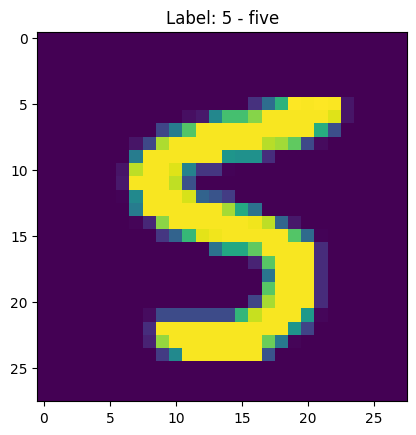

Shape: torch.Size([64, 1, 28, 28])
torch.Size([64, 16, 4, 4])


In [128]:
# Visualize a single image

# Get a Batch of images
images, labels = next(iter(train_dataloader))

# Get a single image from the batch
image = images[0]
label = labels[0]

# Plot the image
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {class_names[label]}")
plt.show()
print(f"Shape: {images.shape}")

patch_embed = nn.Conv2d(in_channels=num_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
embedded_image = patch_embed(images)
print(embedded_image.shape)

In [129]:
# Class for Patch Embedding - Part 1 of the ViT architecture

class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(in_channels=num_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

  # The forward method should be outside __init__ and at the same indentation level as __init__
  def forward(self, x):
    x = self.patch_embed(x)
    x= x.flatten(2).transpose(1, 2)
    return x

In [130]:
# Class for Transformer encoder - Part 2
# Layer Normalization
# Multi head attention
# Layer normalization
# Residuals
# MLP - activation function

class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.layer_norm2 = nn.LayerNorm(embed_dim)

    self.multihead_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(embed_dim, mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim, embed_dim)
    )

  # The forward method should be outside __init__ and at the same indentation level as __init__
  def forward(self, x):
    residual = x
    x = self.layer_norm1(x)
    # Fix: MultiheadAttention returns a tuple, we only need the first element (the attention output)
    x = self.multihead_attention(x, x, x)[0]
    x = residual + x
    residual = x
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = residual + x
    return x

In [131]:
# Class for MLP head for classification
class MLP_Head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.mlp_head = nn.Sequential(
        nn.Linear(embed_dim, mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim, num_classes)
    )

  def forward(self, x):
    x = x[:,0]
    x = self.layer_norm1(x)
    x = self.mlp_head(x)
    return x

In [132]:
class vision_transformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    # Fix: pos_embedding should have a size of 1 + num_patches to account for the cls_token
    self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))
    self.transformer_encoder = TransformerEncoder()
    self.mlp_head = MLP_Head()

  def forward(self, x):
    x = self.patch_embedding(x)
    cls_token = self.cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    x = x + self.pos_embedding
    x = self.transformer_encoder(x)
    x = self.mlp_head(x)
    return x

In [133]:
## Creating model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vision_transformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [134]:
## Training the model
for epoch in range(5):
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0
  for batch_idx, (images, labels) in enumerate(train_dataloader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    preds = outputs.argmax(dim=1)

    correct = (preds == labels).sum().item()
    accuracy = correct / len(labels)

    correct_epoch += correct
    total_epoch += len(labels)

    if batch_idx % 100 == 0:
      print(f"Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

  epoch_loss = total_loss / len(train_dataloader)
  epoch_accuracy = correct_epoch / total_epoch
  print(f"Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch: 1, Batch: 1, Loss: 2.3150, Accuracy: 0.1094
Epoch: 1, Batch: 101, Loss: 1.3287, Accuracy: 0.4844
Epoch: 1, Batch: 201, Loss: 1.0811, Accuracy: 0.6562
Epoch: 1, Batch: 301, Loss: 0.9958, Accuracy: 0.6875
Epoch: 1, Batch: 401, Loss: 0.8799, Accuracy: 0.6719
Epoch: 1, Batch: 501, Loss: 0.8942, Accuracy: 0.7188
Epoch: 1, Batch: 601, Loss: 0.8306, Accuracy: 0.6406
Epoch: 1, Batch: 701, Loss: 0.9615, Accuracy: 0.6875
Epoch: 1, Batch: 801, Loss: 0.8468, Accuracy: 0.7656
Epoch: 1, Batch: 901, Loss: 0.7656, Accuracy: 0.7500
Epoch: 1, Loss: 1.0275, Accuracy: 0.6367
Epoch: 2, Batch: 1, Loss: 0.7281, Accuracy: 0.7656
Epoch: 2, Batch: 101, Loss: 0.4589, Accuracy: 0.8125
Epoch: 2, Batch: 201, Loss: 0.4401, Accuracy: 0.8750
Epoch: 2, Batch: 301, Loss: 0.4960, Accuracy: 0.8281
Epoch: 2, Batch: 401, Loss: 0.5871, Accuracy: 0.8438
Epoch: 2, Batch: 501, Loss: 0.4940, Accuracy: 0.8438
Epoch: 2, Batch: 601, Loss: 0.5962, Accuracy: 0.7812
Epoch: 2, Batch: 701, Loss: 0.6666, Accuracy: 0.7812
Epoch: 2,

In [136]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")


==> Val Accuracy: 87.86%


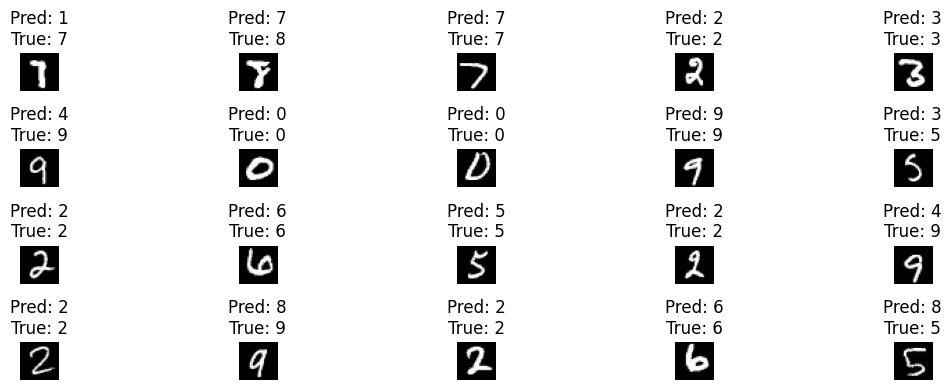

In [140]:
model.eval()
images, labels = next(iter(val_dataloader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Plot 10 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze().cpu(), cmap='gray') # Added .cpu() here
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [142]:
# Get one batch from the validation data
images, labels = next(iter(val_dataloader))

# Print the shape of the images tensor
print("Shape of images in a batch:", images.shape)
patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
embedded_data = patch_embed(images)
embedded_data = embedded_data.flatten(2)
embedded_data = embedded_data.transpose(1,2)
print("Shape of embedded data:", embedded_data.shape)
print(torch.randn(1,1,embed_dim).shape)

# You can also print the shape of the labels tensor if you'd like
# print("Shape of labels in a batch:", labels.shape)

Shape of images in a batch: torch.Size([64, 1, 28, 28])
Shape of embedded data: torch.Size([64, 16, 16])
torch.Size([1, 1, 16])
